Importar bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set_style("whitegrid")

Importar base de dados, definir colunas de interesse e medidas descritivas

In [2]:
df = pd.read_csv("../databases/ENEM_2023_FINAL_num.csv")

cluster_columns = ['TP_DEPENDENCIA_ADM_ESC', 'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'ESCOLARIDADE_PAI', 'ESCOLARIDADE_MAE', 'INTERNET_CASA', 'EST_RENDA_PER_CAP', 'EST_CELULAR_PER_CAP', 'EST_COMP_PER_CAP']

df_cluster = df[cluster_columns]

display(df_cluster.sample(5))
display(df_cluster.describe().T)

,TP_DEPENDENCIA_ADM_ESC,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_MT,NU_NOTA_LC,NU_NOTA_REDACAO,ESCOLARIDADE_PAI,ESCOLARIDADE_MAE,INTERNET_CASA,EST_RENDA_PER_CAP,EST_CELULAR_PER_CAP,EST_COMP_PER_CAP
652,Estadual,404.0,414.7,482.1,508.8,740.0,ES incompleto,ES incompleto,True,330.001000,0.600,0.200000
4288,Estadual,569.0,583.1,693.8,589.3,600.0,ES incompleto,ES incompleto,True,924.001000,0.900,0.200000
5397,Privada,613.2,533.2,686.0,608.3,780.0,EM incompleto,EM incompleto,True,4180.001667,1.000,0.333333
6084,Estadual,496.4,467.6,475.3,530.1,480.0,ES incompleto,PG completo,True,1155.001250,1.125,0.250000
4416,Privada,490.3,530.9,380.3,560.1,580.0,PG completo,ES incompleto,True,2420.001667,1.000,1.000000


,count,mean,std,min,25%,50%,75%,max
NU_NOTA_CH,10000.0,553.113870,79.871978,0.0,507.07500,560.850000,607.800000,800.600
NU_NOTA_CN,10000.0,520.955930,86.988639,0.0,462.10000,519.700000,574.725000,842.800
NU_NOTA_MT,10000.0,590.072610,128.398194,0.0,494.10000,596.000000,682.925000,958.600
NU_NOTA_LC,10000.0,548.073540,65.110314,0.0,510.50000,552.800000,593.300000,766.000
NU_NOTA_REDACAO,10000.0,665.690000,177.056146,0.0,560.00000,660.000000,800.000000,1000.000
EST_RENDA_PER_CAP,10000.0,2158.449645,2423.361817,0.0,577.50125,1155.002500,2805.001250,23100.005
EST_CELULAR_PER_CAP,10000.0,0.892048,0.303331,0.0,0.75000,1.000000,1.125000,2.250
EST_COMP_PER_CAP,10000.0,0.407196,0.360174,0.0,0.20000,0.333333,0.666667,2.250


Visualização dos outliers

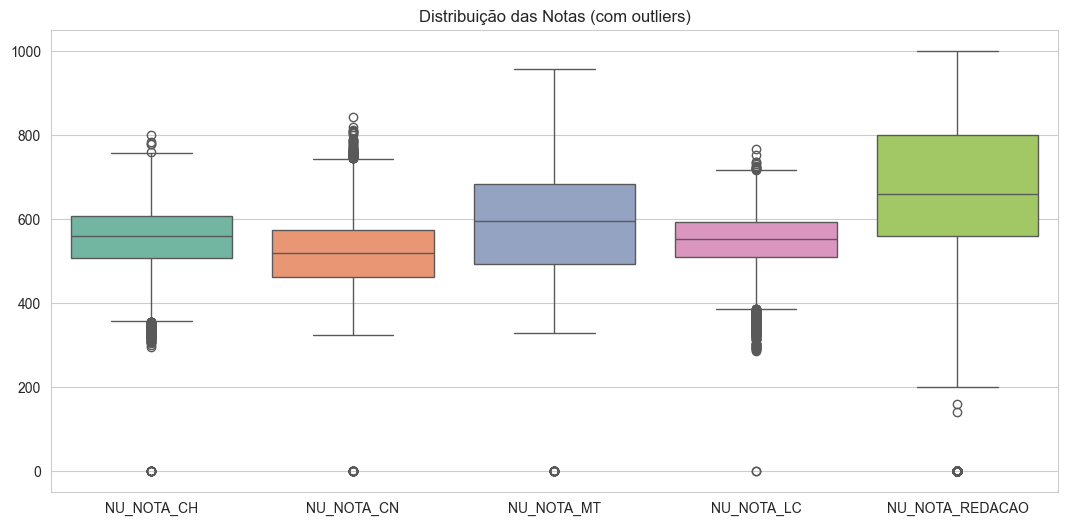

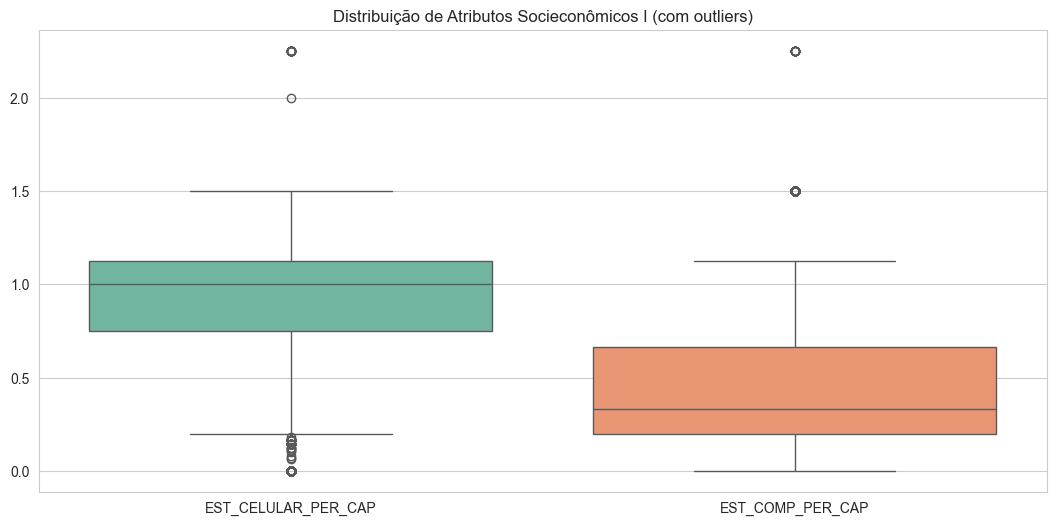

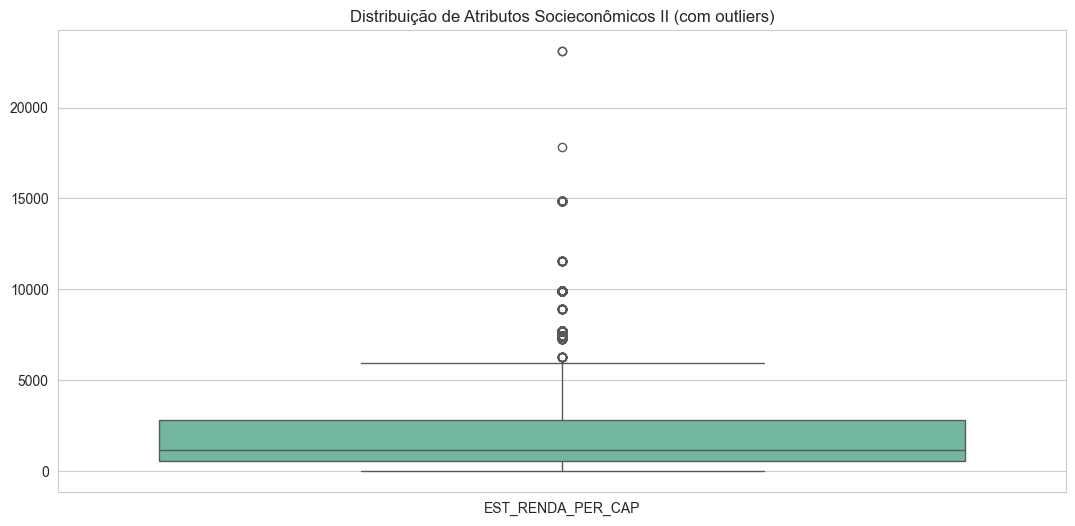

In [3]:
def gerar_boxplot(columns:list[str], title:str):
    plt.figure(figsize=(13, 6))
    plt.title(title)
    sns.boxplot(data=df_cluster[columns], orient='v', palette="Set2")
    plt.show()


notas_columns = ['NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']
gerar_boxplot(notas_columns, "Distribuição das Notas (com outliers)")

socioeconomicas1_columns = ['EST_CELULAR_PER_CAP', 'EST_COMP_PER_CAP']
gerar_boxplot(socioeconomicas1_columns, "Distribuição de Atributos Socieconômicos I (com outliers)")

socioeconomicas2_columns = ['EST_RENDA_PER_CAP']
gerar_boxplot(socioeconomicas2_columns, "Distribuição de Atributos Socieconômicos II (com outliers)")

Overview dos outliers

In [4]:
def overview_outliers_for_column(df:pd.DataFrame, col:str) -> dict:    
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    inf = Q1 - 1.5 * (Q3 - Q1)
    sup = Q3 + 1.5 * (Q3 - Q1)
    outliers_inf = df[df[col] < inf].shape[0]
    outliers_sup = df[df[col] > sup].shape[0]

    return {
        "COLUNA": col,
        "LIMITE_INF": inf,
        "LIMITE_SUP": sup,
        "N_OUTLIERS_INF": outliers_inf,
        "N_OUTLIERS_SUP": outliers_sup,
        "TOTAL_OUTLIERS": outliers_inf + outliers_sup
    }

def overview_outliers(df:pd.DataFrame, columns:list[str]):
    results = [overview_outliers_for_column(df, col) for col in columns]
    return pd.DataFrame(results).set_index("COLUNA")

columns = ['NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'EST_RENDA_PER_CAP', 'EST_CELULAR_PER_CAP', 'EST_COMP_PER_CAP']
outliers_overview = overview_outliers(df_cluster, columns)

display(outliers_overview)

,LIMITE_INF,LIMITE_SUP,N_OUTLIERS_INF,N_OUTLIERS_SUP,TOTAL_OUTLIERS
COLUNA,,,,,
NU_NOTA_CH,355.98750,758.887500,164,5,169
NU_NOTA_CN,293.16250,743.662500,27,63,90
NU_NOTA_MT,210.86250,966.162500,25,0,25
NU_NOTA_LC,386.30000,717.500000,172,13,185
NU_NOTA_REDACAO,200.00000,1160.000000,155,0,155
EST_RENDA_PER_CAP,-2763.74875,6146.251250,0,781,781
EST_CELULAR_PER_CAP,0.18750,1.687500,251,23,274
EST_COMP_PER_CAP,-0.50000,1.366667,0,169,169


Marcar e remover os outliers

In [5]:
def remover_outliers_tukey(df: pd.DataFrame, colunas: list[str]) -> pd.DataFrame:
    outlier_geral_mask = pd.Series(False, index=df.index)
    
    for col in colunas:
        if col not in df.columns:
            continue
            
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        
        mask_outlier_col = (df[col] < limite_inferior) | (df[col] > limite_superior)
        
        outlier_geral_mask = outlier_geral_mask | mask_outlier_col

    df_sem_outliers = df[~outlier_geral_mask].copy()
    
    return df_sem_outliers

columns = ['NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'NU_NOTA_REDACAO', 'EST_RENDA_PER_CAP', 'EST_CELULAR_PER_CAP', 'EST_COMP_PER_CAP']
df_cluster_clean = remover_outliers_tukey(df_cluster, columns)
display(df_cluster_clean)

,TP_DEPENDENCIA_ADM_ESC,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_MT,NU_NOTA_LC,NU_NOTA_REDACAO,ESCOLARIDADE_PAI,ESCOLARIDADE_MAE,INTERNET_CASA,EST_RENDA_PER_CAP,EST_CELULAR_PER_CAP,EST_COMP_PER_CAP
1,Estadual,583.3,474.1,564.6,599.3,660.0,EM incompleto,PG incompleto,True,1188.001000,0.900,0.400000
2,Privada,646.5,620.7,801.6,585.7,740.0,PG completo,PG completo,True,2475.001250,0.750,1.125000
3,Privada,553.4,495.1,605.8,554.6,880.0,PG incompleto,PG incompleto,True,2475.001250,1.125,0.500000
4,Privada,616.3,589.7,682.8,636.7,860.0,PG incompleto,PG incompleto,True,3300.001667,1.000,1.000000
5,Estadual,549.8,565.9,624.0,608.9,780.0,EF-1 incompleto,ES incompleto,True,550.001667,1.000,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...
9994,Privada,572.5,581.2,629.3,525.9,640.0,EM incompleto,ES incompleto,True,3630.002500,1.000,0.500000
9995,Privada,609.1,613.6,725.2,570.7,800.0,PG completo,PG completo,True,4950.000833,0.750,0.750000
9996,Estadual,471.6,488.4,597.6,556.4,820.0,EF-2 incompleto,EF-2 incompleto,True,742.501250,1.125,0.500000
9997,Privada,579.6,616.6,674.5,627.2,580.0,ES incompleto,ES incompleto,True,1155.001250,1.125,1.125000


Padronizar escala

In [6]:
def padronizar_zscore(df:pd.DataFrame, columns:list[str]):
    scaler = StandardScaler()

    dados_padronizados_np = scaler.fit_transform(df[columns])

    df_padronizado = pd.DataFrame(
        dados_padronizados_np,
        columns=columns,
        index=df.index
    )
    
    return df_padronizado, scaler

df_padronizado, scaler = padronizar_zscore(df_cluster_clean, columns)

Método Hierarquico

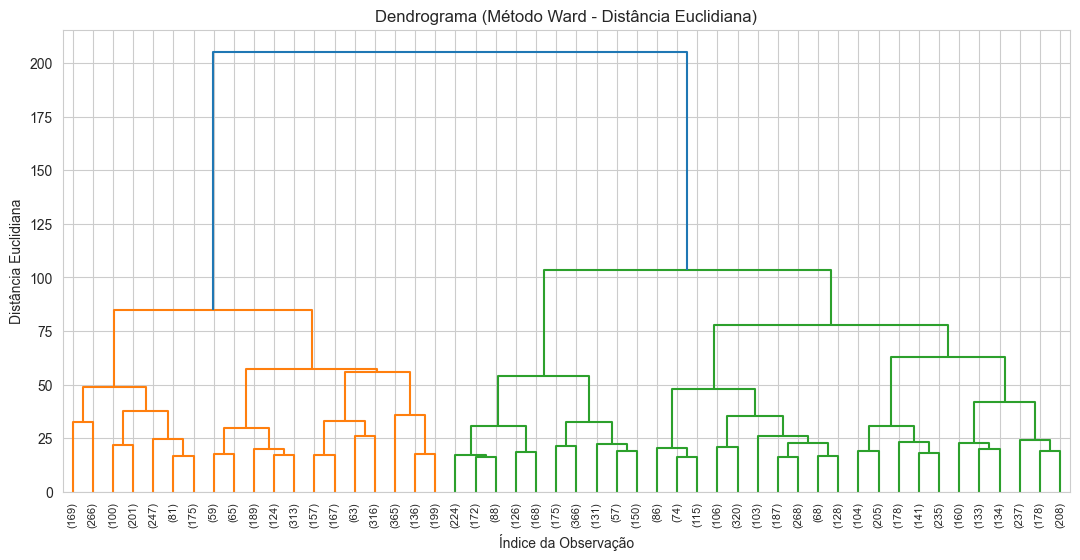

In [7]:
def plotar_dendrograma(df_padronizado:pd.DataFrame):
    Z = linkage(df_padronizado, method='ward', metric='euclidean')

    plt.figure(figsize=(13, 6))
    plt.title('Dendrograma (Método Ward - Distância Euclidiana)')
    plt.xlabel('Índice da Observação')
    plt.ylabel('Distância Euclidiana')
    
    dendrogram(
        Z,
        leaf_rotation=90.,  # Gira os rótulos do eixo X
        leaf_font_size=8.,  # Tamanho da fonte
        truncate_mode='lastp',
        p=50,
        show_leaf_counts=True,
        color_threshold=None # A cor padrão azul é aplicada a todo o gráfico
    )
    plt.show()
    
    return Z

Z_linkage = plotar_dendrograma(df_padronizado)

Métodos não Hierarquicos

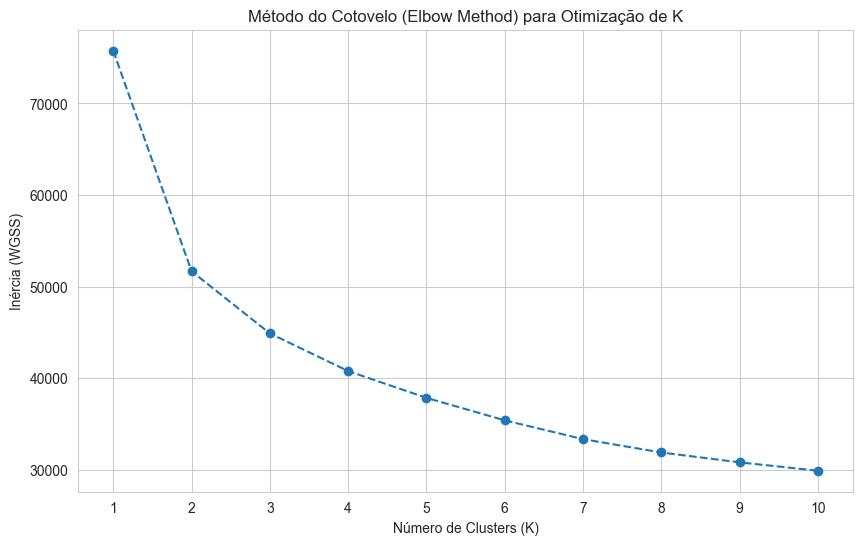

In [8]:
def plotar_elbow_method(df_padronizado: pd.DataFrame, max_k: int = 10):
    inertia_scores = []
    
    # Testar de K=1 (para começar o gráfico) até K=max_k
    K_range = range(1, max_k + 1)
    
    # Rodar K-Means para cada K
    for k in K_range:
        # random_state garante que os resultados sejam reproduzíveis
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(df_padronizado)
        inertia_scores.append(kmeans.inertia_)
        
    # Plotar
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, inertia_scores, marker='o', linestyle='--')
    plt.title('Método do Cotovelo (Elbow Method) para Otimização de K')
    plt.xlabel('Número de Clusters (K)')
    plt.ylabel('Inércia (WGSS)')
    plt.xticks(K_range)
    plt.show()
    
    return inertia_scores

inertia_scores = plotar_elbow_method(df_padronizado, max_k=10)

K=2: Silhouette Score = 0.2631
K=3: Silhouette Score = 0.1850
K=4: Silhouette Score = 0.1673
K=5: Silhouette Score = 0.1571
K=6: Silhouette Score = 0.1559
K=7: Silhouette Score = 0.1509
K=8: Silhouette Score = 0.1466
K=9: Silhouette Score = 0.1410
K=10: Silhouette Score = 0.1321


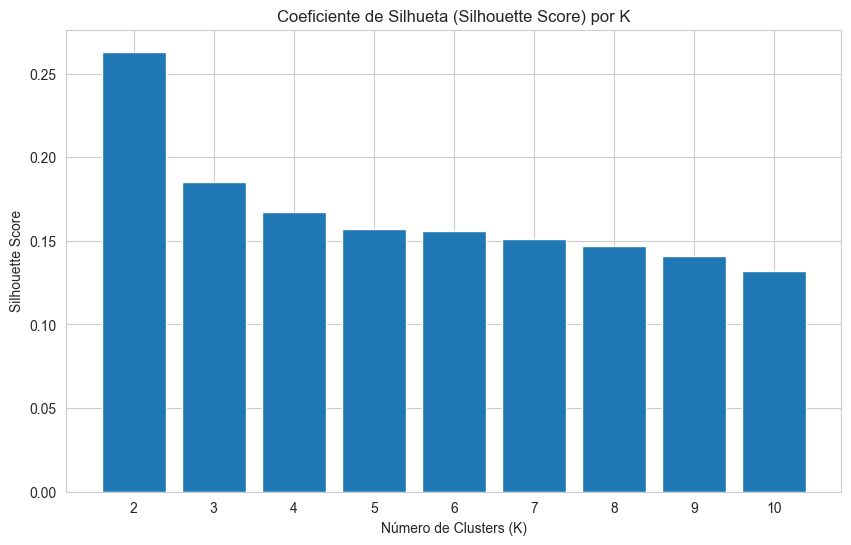

In [9]:
def plotar_silhouette_score(df_padronizado: pd.DataFrame, max_k: int = 10):
    silhouette_scores = {}
    
    # Testar de K=2 (score não é definido para K=1) até K=max_k
    K_range = range(2, max_k + 1)

    # Rodar K-Means e calcular o Score para cada K
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(df_padronizado)
        score = silhouette_score(df_padronizado, labels)
        silhouette_scores[k] = score
        print(f"K={k}: Silhouette Score = {score:.4f}")
        
    # Plotar
    plt.figure(figsize=(10, 6))
    plt.bar(silhouette_scores.keys(), silhouette_scores.values())
    plt.title('Coeficiente de Silhueta (Silhouette Score) por K')
    plt.xlabel('Número de Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.xticks(list(K_range))
    plt.show()
    
    return silhouette_scores

# Exemplo de Uso
silhouette_results = plotar_silhouette_score(df_padronizado, max_k=10)

K-Means

In [10]:
K_FINAL = 2
kmeans_final = KMeans(n_clusters=K_FINAL, random_state=42, n_init=10)
kmeans_final.fit(df_padronizado)

# 2. Atribuir o Cluster ao DataFrame original
# Usamos o índice do df_padronizado para garantir que a atribuição seja correta
df_cluster_clean['CLUSTER'] = kmeans_final.labels_

print("="*50)
print(f"ETAPA 7.3 CONCLUÍDA: Atribuição dos {K_FINAL} Clusters")
print(f"Distribuição dos Clusters:")
print(df_cluster_clean['CLUSTER'].value_counts())
print("="*50)

ETAPA 7.3 CONCLUÍDA: Atribuição dos 2 Clusters
Distribuição dos Clusters:
CLUSTER
0    4376
1    4041
Name: count, dtype: int64


Análise dos perfis

In [11]:
columns = ['NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'NU_NOTA_REDACAO', 'EST_RENDA_PER_CAP', 'EST_CELULAR_PER_CAP', 'EST_COMP_PER_CAP']
perfil_clusters = df_cluster_clean.groupby('CLUSTER')[columns].agg(
    ['mean', 'std', 'count']
)

display(perfil_clusters.loc[:, (slice(None), 'mean')].droplevel(1, axis=1).round(2))

display(perfil_clusters.loc[:, (slice(None), 'count')].droplevel(1, axis=1).iloc[:, 0].rename('N_Observacoes'))

,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_MT,NU_NOTA_LC,NU_NOTA_REDACAO,NU_NOTA_REDACAO,EST_RENDA_PER_CAP,EST_CELULAR_PER_CAP,EST_COMP_PER_CAP
CLUSTER,,,,,,,,,
0,511.72,472.94,511.20,515.27,577.44,577.44,1012.93,0.83,0.24
1,601.98,568.55,666.77,586.97,773.11,773.11,2291.36,0.97,0.49


CLUSTER
0    4376
1    4041
Name: N_Observacoes, dtype: int64

Plot de Gráfico Radar

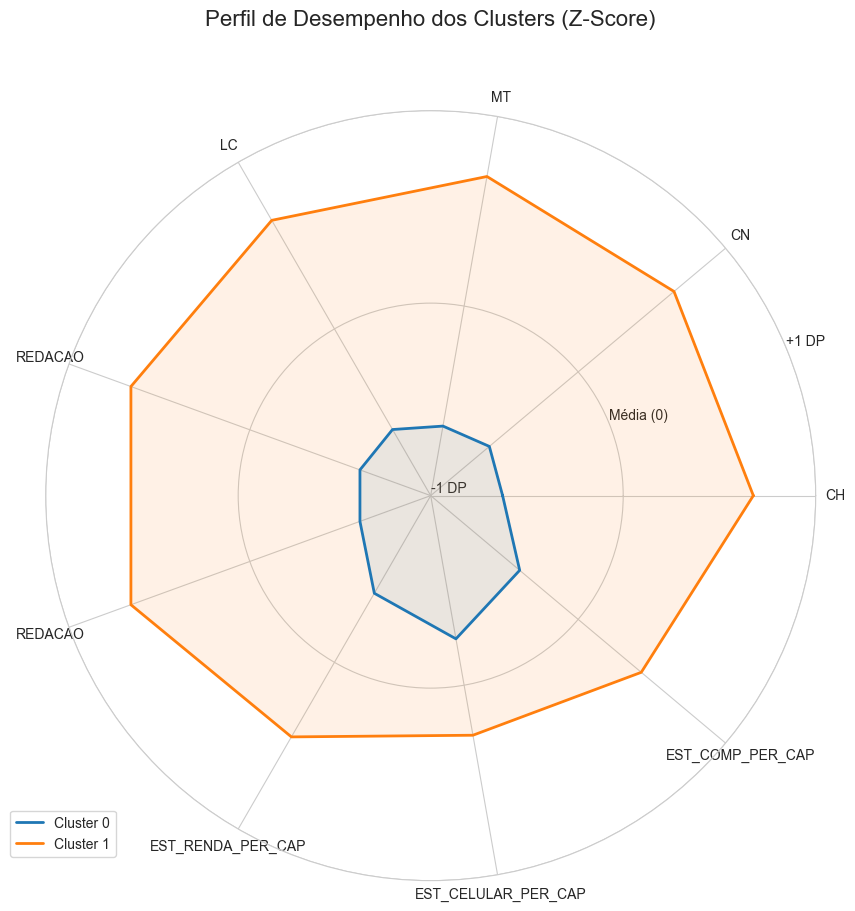

In [12]:
centroides_padronizados = pd.DataFrame(
    kmeans_final.cluster_centers_, 
    columns=columns, 
    index=[f'Cluster {i}' for i in range(K_FINAL)]
)

# 2. Configuração do Radar
categorias = columns
N = len(categorias)

# O ângulo de cada eixo no gráfico de radar
angulos = [n / float(N) * 2 * np.pi for n in range(N)]
angulos += angulos[:1]

plt.figure(figsize=(10, 10))

# 3. Plotagem para cada Cluster
for i, cluster in centroides_padronizados.iterrows():
    valores = cluster.values.flatten().tolist()
    valores += valores[:1] # Fecha o círculo

    ax = plt.subplot(111, polar=True)
    ax.plot(angulos, valores, linewidth=2, linestyle='solid', label=i)
    ax.fill(angulos, valores, alpha=0.1)

# 4. Ajustes Finais do Gráfico
ax.set_xticks(angulos[:-1])
ax.set_xticklabels([c.replace('NU_NOTA_', '') for c in categorias]) # Rótulos mais limpos
ax.set_yticks([-1.0, 0.0, 1.0])
ax.set_yticklabels(['-1 DP', 'Média (0)', '+1 DP'])
ax.set_title('Perfil de Desempenho dos Clusters (Z-Score)', size=16, y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

Mais Análises de Distribuição por Clusters

In [19]:
def crosstable_by_cluster(df:pd.DataFrame, column_name:str)->pd.DataFrame:
    return pd.crosstab(
        index = df[column_name],
        columns = df['CLUSTER'],
    )

display(crosstable_by_cluster(df_cluster_clean, 'TP_DEPENDENCIA_ADM_ESC'))
display(crosstable_by_cluster(df_cluster_clean, 'ESCOLARIDADE_MAE'))
display(crosstable_by_cluster(df_cluster_clean, 'ESCOLARIDADE_PAI'))

CLUSTER,0,1
TP_DEPENDENCIA_ADM_ESC,,
Estadual,3065,1241
Federal,17,61
Municipal,30,9
Privada,1264,2730


CLUSTER,0,1
ESCOLARIDADE_MAE,,
EF-1 incompleto,214,74
EF-2 incompleto,313,138
EM incompleto,524,207
ES incompleto,1963,1218
Nunca estudou,26,5
PG completo,496,1111
PG incompleto,840,1288


CLUSTER,0,1
ESCOLARIDADE_PAI,,
EF-1 incompleto,403,147
EF-2 incompleto,539,231
EM incompleto,674,324
ES incompleto,1806,1305
Nunca estudou,50,15
PG completo,282,906
PG incompleto,622,1113
